# 필요한 라이브러리들을 불러옵니다.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import geopandas as gpd

# 파일 로드


In [2]:
hdi_file = '/content/Human_Development_Index_20240115174853.csv'
best_countries_file = '/content/best-countries-to-live-in-2024.csv'
world_populations_file = '/content/world-country-populations.csv'

# 데이터 읽기


In [18]:
hdi_data = pd.read_csv(hdi_file)
best_countries_data = pd.read_csv(best_countries_file)
world_populations_data = pd.read_csv(world_populations_file)

hdi_data.head()
best_countries_data.head()
world_populations_data.head()

,population_in_2023,population_in_2022,city,country,population_growthRate,type
0,37194105,37274002,Tokyo,Japan,-0.0021,w
1,32941309,32065760,Delhi,India,0.0273,w
2,29210808,28516903,Shanghai,China,0.0243,w
3,23209616,22478117,Dhaka,Bangladesh,0.0325,w
4,22619736,22429799,Sao Paulo,Brazil,0.0085,w


# 데이터 정제 및 전처리
# HDI 데이터 전처리

In [4]:
hdi_data = hdi_data.drop(0)
hdi_data = hdi_data.rename(columns={"by country": "Country"})
hdi_data.iloc[:, 1:] = hdi_data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# 상위 10개국 추출 및 시계열 데이터 준비


In [5]:
top_countries_2021 = hdi_data.sort_values(by='2021', ascending=False).head(10)['Country']
top_countries_hdi_data = hdi_data[hdi_data['Country'].isin(top_countries_2021)]
top_countries_hdi_data_transposed = top_countries_hdi_data.set_index('Country').transpose()

# 통계적 분석
# 상관계수 계산

In [17]:
population_growth_hdi = best_countries_data[['population_growthRate', 'Hdi2021']].dropna()
correlation = population_growth_hdi.corr()
print(correlation)

                       population_growthRate   Hdi2021
population_growthRate               1.000000 -0.699115
Hdi2021                            -0.699115  1.000000


# 선형 회귀 모델


In [7]:
X = population_growth_hdi['population_growthRate']
y = population_growth_hdi['Hdi2021']
X = sm.add_constant(X) # 상수항 추가
model = sm.OLS(y, X).fit()

# 시계열 분석
# 대표 국가의 HDI 시계열 데이터 추출

In [8]:
usa_hdi_data = hdi_data[hdi_data['Country'] == 'United States'].iloc[:, 1:].transpose()
usa_hdi_data.columns = ['HDI']
usa_hdi_data.index = pd.to_datetime(usa_hdi_data.index, format='%Y')

# 시계열 분해

In [9]:
decomposition = sm.tsa.seasonal_decompose(usa_hdi_data['HDI'], model='additive', period=1)

# 그룹별 분석
# 대륙별 평균 HDI 계산

In [10]:
region_data = best_countries_data.groupby('region').agg({'Hdi2021': 'mean'}).reset_index()

# 고급 통계적 모델링
# 다중 선형 회귀

In [11]:
best_countries_data['population_density'] = pd.to_numeric(best_countries_data['population_density'], errors='coerce')
X_mult = best_countries_data[['population_growthRate', 'population_density']].dropna()
y_mult = best_countries_data.loc[X_mult.index, 'Hdi2021']
X_mult = sm.add_constant(X_mult) # 상수항 추가
model_mult = sm.OLS(y_mult, X_mult).fit()

# 결과 해석 및 의미
# 다중 선형 회귀 모델 결과 해석

In [12]:
mult_regression_summary = model_mult.summary()

# 시각화 및 결과 해석
# HDI 시계열 차트

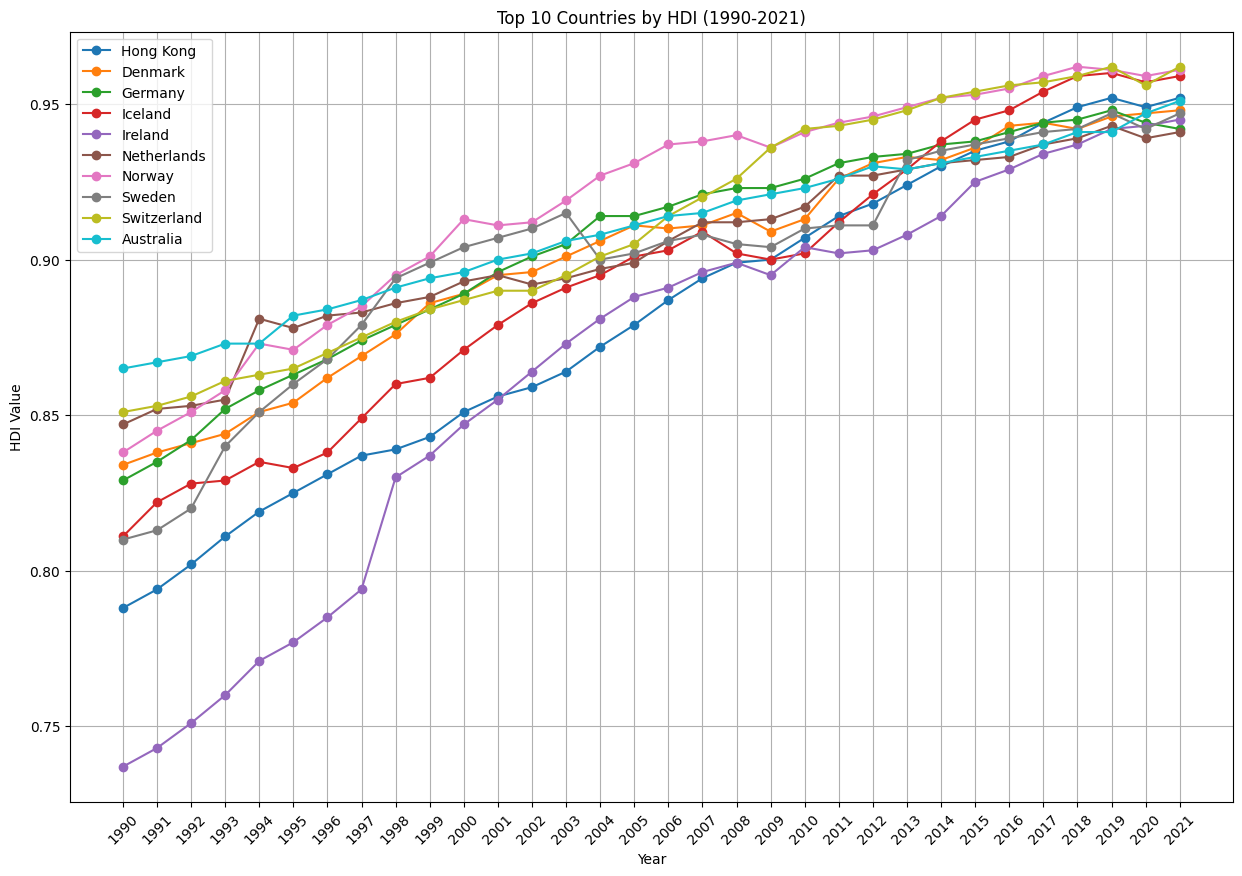

In [13]:
plt.figure(figsize=(15, 10))
for country in top_countries_hdi_data_transposed.columns:
    plt.plot(top_countries_hdi_data_transposed.index, top_countries_hdi_data_transposed[country], label=country, marker='o')
plt.title('Top 10 Countries by HDI (1990-2021)')
plt.xlabel('Year')
plt.ylabel('HDI Value')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# 인구 성장률과 HDI의 상관관계 시각화


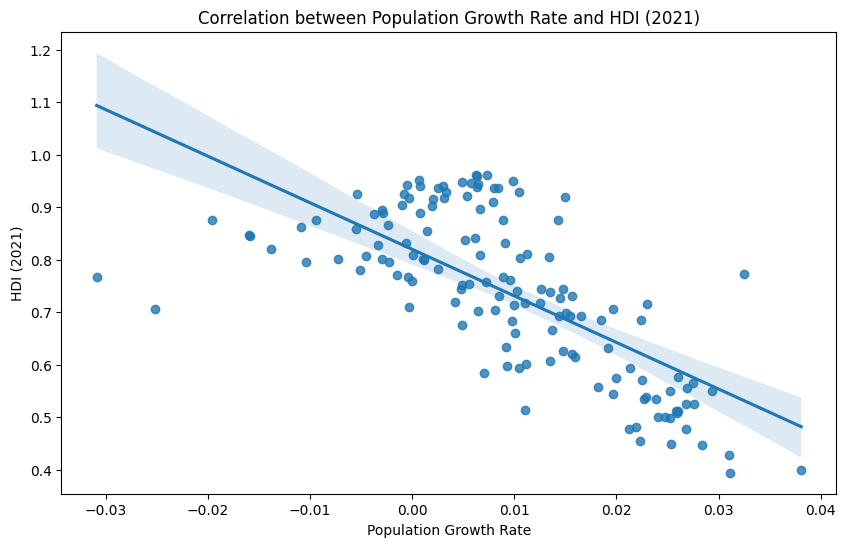

In [14]:
plt.figure(figsize=(10, 6))
sns.regplot(x='population_growthRate', y='Hdi2021', data=population_growth_hdi)
plt.title('Correlation between Population Growth Rate and HDI (2021)')
plt.xlabel('Population Growth Rate')
plt.ylabel('HDI (2021)')
plt.show()

# 대륙별 평균 HDI 시각화


<ipython-input-15-3370b54462ad>:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


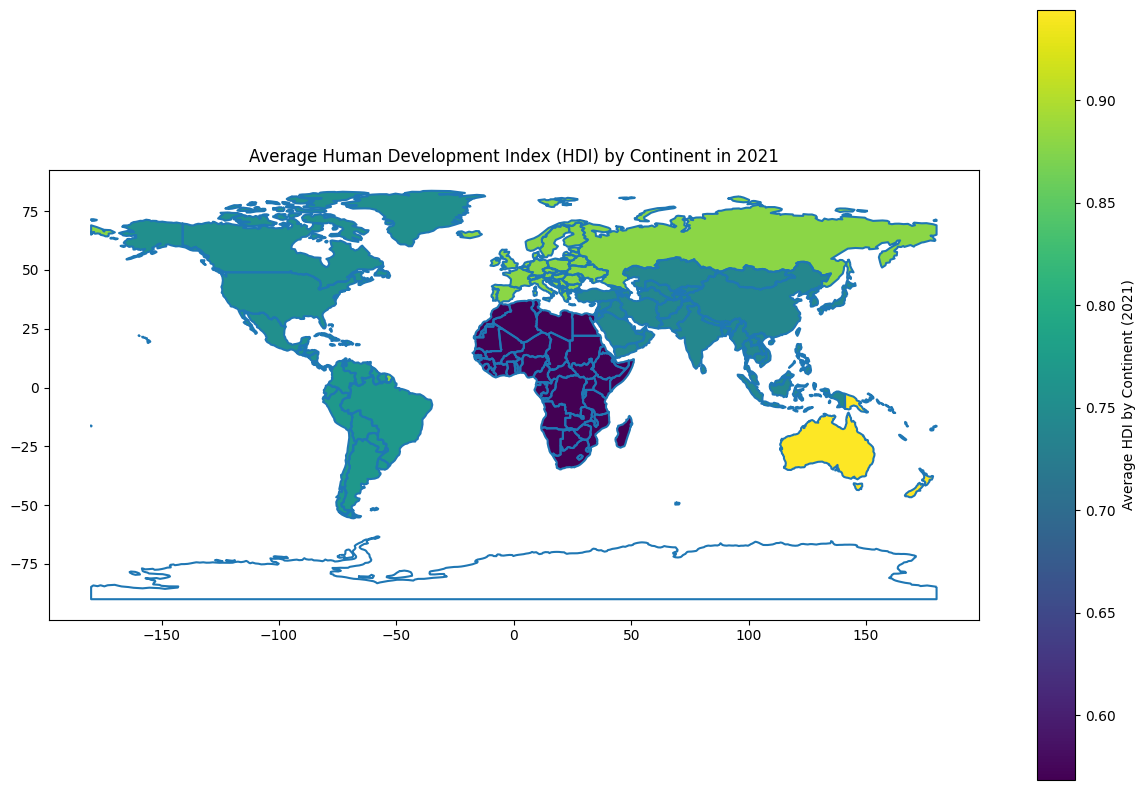

In [15]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(region_data, how='left', left_on='continent', right_on='region')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)
world.plot(column='Hdi2021', ax=ax, legend=True, legend_kwds={'label': "Average HDI by Continent (2021)"})
plt.title('Average Human Development Index (HDI) by Continent in 2021')
plt.show()

# 다중 선형 회귀 모델 결과 해석

In [16]:
print(mult_regression_summary)


                            OLS Regression Results                            
Dep. Variable:                Hdi2021   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     70.97
Date:                Thu, 18 Jan 2024   Prob (F-statistic):           6.38e-22
Time:                        15:03:16   Log-Likelihood:                 114.22
No. Observations:                 141   AIC:                            -222.4
Df Residuals:                     138   BIC:                            -213.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.81